In order to import the data and allow the notebook to access files, we mount Google Drive and grant permissions.

In [14]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Let's also import any libraries that we will be needing here.

In [30]:
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

Next, we read our CSV file from the appropriate directory and store it as a 2D array of strings. We will store the data in a pandas dataFrame which is easily compatible with tensorflow. The dataFrame behaves as a 2D array which means lookups are efficient.

The CSV should follow a certain format: the first two rows are headers and labels and the remaining rows contain data.

In [73]:
#find the path to our CSV file within google drive and pass it as an argument to the open call.
#the path will begin with /content/drive/My Drive/ in most cases.
CHFdata = pd.read_csv('/content/drive/My Drive/Heart Failure AI/CHF Data.csv', header=1, dtype=str)
CHFdata.dtypes

monty, year, case #                                            object
Admission Date                                                 object
Age                                                            object
Gender                                                         object
BMI                                                            object
Zip Code                                                       object
Echocardiogram LVEF (%)                                        object
Troponin (highest)                                             object
Hemoglobin A1C                                                 object
Creat (Chem 7 within 24 hours of admission)                    object
GFR                                                            object
BNP (Initial, B-type naturetic peptide)                        object
Urine Tox negative (0) or per history                          object
Urine Tox Pos Stimulant (1)                                    object
Urine Tox Pos Benzo 

In [ ]:
CHFdata

,"monty, year, case #",Admission Date,Age,Gender,BMI,Zip Code,Echocardiogram LVEF (%),Troponin (highest),Hemoglobin A1C,Creat (Chem 7 within 24 hours of admission),GFR,"BNP (Initial, B-type naturetic peptide)",Urine Tox negative (0) or per history,Urine Tox Pos Stimulant (1),Urine Tox Pos Benzo (2),Urine Tox Positive Opiate (3),Urine Tox Positive THC (4),Smoking Currently (Yes/ No),Former Smoker,Smoking (Pack Year History),Marijuana (THC),Alcohol (low/high),30 day readmission,60 day readmission,30 day death,60 day death,90 day death,DM,Hypertension,Coronary Artery Disease,Prior Stroke / TIA / Cerebral Vascular Ischemia,Atrial Fibrillation,Peripheral vascular disease,Obstructive Sleep Apnea,"Aortic Stenosis 0 = No, 1= yes / mild, 2=moderate, 3=severe",Dialysis
0,1,3/31/2018,78,M,26.22,95828,65,0.11,6.5,1.19,58,454,0,0,0,0,0,0,1,20,0,0,No,No,No,No,No,Yes,Yes,No,No,Yes,No,No,NaN,NaN
1,2,4/3/2018,66,M,28.18,95833,15,0.03,5.5,1.78,45,2103,0,0,0,0,0,0,1,38,0,1,Yes,Yes,No,No,No,No,Yes,Yes,No,No,No,No,NaN,NaN
2,3,4/6/2018,86,M,19.77,95691,31,0.11,5.5,1.32,52,136,0,0,0,0,0,0,1,31,0,0,No,No,No,No,No,Yes,Yes,Yes,No,No,No,No,NaN,NaN
3,4,4/6/2018,79,M,23.4,95829,35,0.06,5.4,2.37,29,1362,0,0,0,0,0,0,1,0,0,1,Yes,No,Yes,Yes,Yes,No,Yes,No,No,Yes,No,No,NaN,NaN
4,5,4/7/2018,58,M,31.13,94565,49,0.44,5.5,2.17,31,180,1,0,1,1,0,0,1,34,1,0,Yes,Yes,No,No,No,No,Yes,Yes,No,Yes,No,No,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,101815,10/20/18,78,M,23.1,95831,33,0.03,5.5,0.87,83,1745,0,0,0,0,0,0,1,50,0,0,No,No,No,No,No,No,Yes,No,No,Yes,No,No,0,No
116,101816,10/14/18,81,F,16.59,95824,65,0.02,6.6,2.29,19,1372,0,0,0,0,0,0,0,0,0,0,No,Yes,No,No,No,Yes,Yes,Yes,No,No,No,No,0,No
117,101817,10/2/18,68,F,38.74,95822,42,0.05,11.4,1.13,58,278,0,0,0,0,0,0,0,0,0,0,Yes,No,No,No,No,Yes,Yes,Yes,No,No,Yes,Yes,0,No
118,101818,10/10/18,78,M,29.95,95822,19,0.05,6.6,1.03,69,1798,0,0,0,0,0,0,1,20,0,1,No,Yes,No,No,No,Yes,No,Yes,Yes,Yes,Yes,No,0,No


We see that our data is stored in the type "object" which encompasses the python string type, str. However, we would want to store some values as integers, booleans, or floats so that they represent actual numbers rather than characters so we do some casting.

In [74]:
#convert yes and no to True and False respectively as a bool
yesNoList = ['30 day readmission', '60 day readmission', '30 day death', '60 day death', '90 day death', 'DM', 'Hypertension',
             'Coronary Artery Disease', 'Prior Stroke / TIA / Cerebral Vascular Ischemia', 'Atrial Fibrillation', 
             'Peripheral vascular disease', 'Obstructive Sleep Apnea', 'Dialysis']
#convert 1 and 0 to True and False respectively as a bool
intBoolList = ['Urine Tox negative (0) or per history', 'Urine Tox Pos Stimulant (1)', 'Urine Tox Pos Benzo (2)',
               'Urine Tox Positive Opiate (3)', 'Urine Tox Positive THC (4)', 'Smoking Currently (Yes/ No)', 'Former Smoker',
               'Marijuana (THC)', 'Alcohol (low/high)']
#convert strings to appropirate types
convert_dict = {'Age': float, 'BMI': float, 'Echocardiogram LVEF (%)': float, 'Troponin (highest)': float, 'Hemoglobin A1C': float, 'Creat (Chem 7 within 24 hours of admission)': float, 'BNP (Initial, B-type naturetic peptide)': float, 'GFR': float, 'DM': bool, 'Prior Stroke / TIA / Cerebral Vascular Ischemia': bool, 'Atrial Fibrillation': bool, 'Peripheral vascular disease': bool, 'Obstructive Sleep Apnea': bool, 'Gender': bool} 
for i in yesNoList:
    CHFdata[i] = CHFdata[i].map({'Yes':True, 'No':False})
for j in intBoolList:
    CHFdata[j] = CHFdata[j].map({'1':True, '0':False})
CHFdata['Gender'] = CHFdata['Gender'].map({'M': False, 'F': True})
CHFdata = CHFdata.astype(convert_dict) 
CHFdata.dtypes

monty, year, case #                                             object
Admission Date                                                  object
Age                                                            float64
Gender                                                            bool
BMI                                                            float64
Zip Code                                                        object
Echocardiogram LVEF (%)                                        float64
Troponin (highest)                                             float64
Hemoglobin A1C                                                 float64
Creat (Chem 7 within 24 hours of admission)                    float64
GFR                                                            float64
BNP (Initial, B-type naturetic peptide)                        float64
Urine Tox negative (0) or per history                             bool
Urine Tox Pos Stimulant (1)                                       bool
Urine 

Using matplotlib, we can visualize some of the data and perform some simple data analysis. Visualizing the data can also help to pinpoint sources of bias. Tools in the seaborn library allow us to plot a histogram and density curve together for easy visualization.

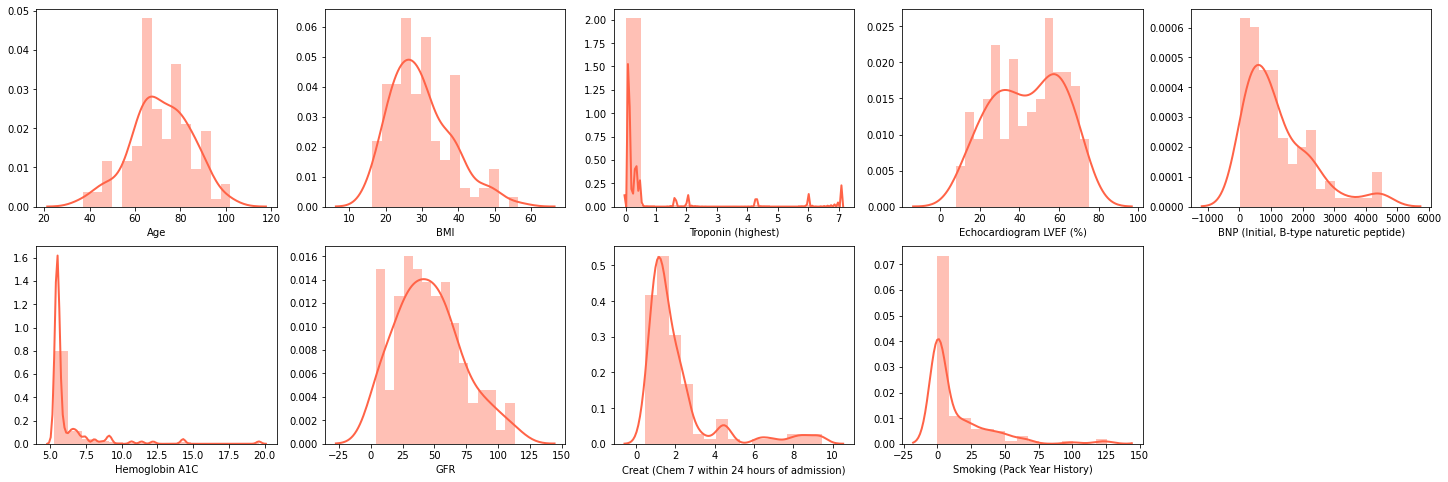

In [75]:
graphList = ['Age','BMI','Troponin (highest)','Echocardiogram LVEF (%)','BNP (Initial, B-type naturetic peptide)','Hemoglobin A1C','GFR','Creat (Chem 7 within 24 hours of admission)','Smoking (Pack Year History)']
graphs = plt.figure(figsize=(25,8))
#plt.title('Patient Data Distributions')
for k in range(1,len(graphList) + 1):
    graphs.add_subplot(2,5,k)
    sns.distplot(CHFdata[graphList[k-1]], hist=True, kde=True, bins=int(len(CHFdata)/8), color = 'tomato', kde_kws={'linewidth': 2})
    #plt.ylabel('Frequency')
    #plt.title(graphList[k-1] + ' distribution')

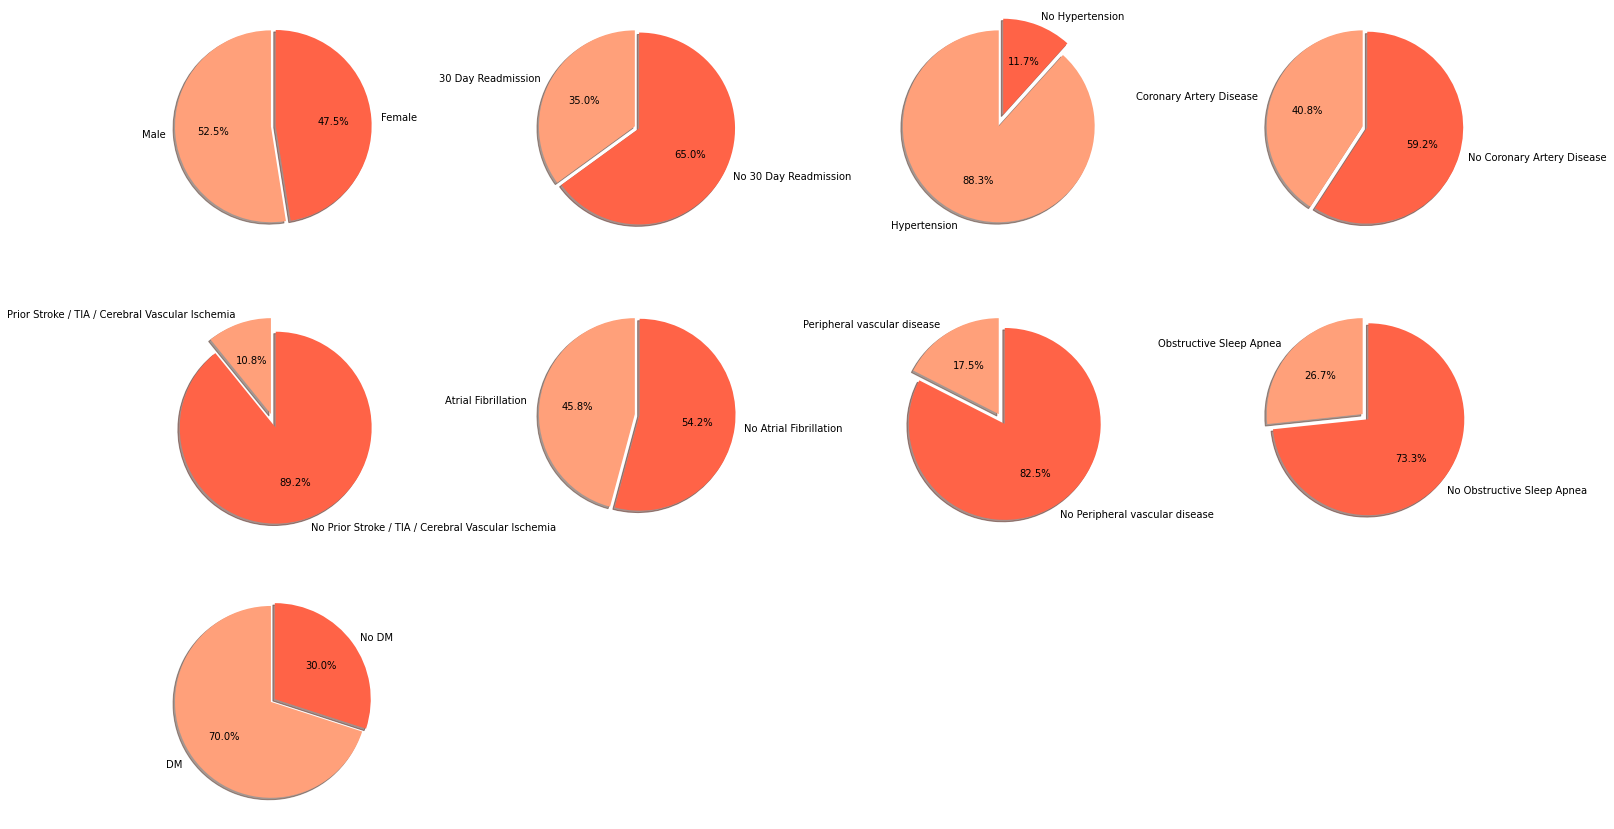

In [76]:
pie = plt.figure(figsize=(25,15))

pie.add_subplot(3,4,1)
sizes = [CHFdata.loc[CHFdata['Gender'] == False].shape[0], CHFdata.loc[CHFdata['Gender'] == True].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Male', 'Female'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,2)
sizes = [CHFdata.loc[CHFdata['30 day readmission'] == 1].shape[0], CHFdata.loc[CHFdata['30 day readmission'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['30 Day Readmission', 'No 30 Day Readmission'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,3)
sizes = [CHFdata.loc[CHFdata['Hypertension'] == 1].shape[0], CHFdata.loc[CHFdata['Hypertension'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.13), labels=['Hypertension ', 'No Hypertension'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,4)
sizes = [CHFdata.loc[CHFdata['Coronary Artery Disease'] == 1].shape[0], CHFdata.loc[CHFdata['Coronary Artery Disease'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Coronary Artery Disease ', 'No Coronary Artery Disease'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,5)
sizes = [CHFdata.loc[CHFdata['Prior Stroke / TIA / Cerebral Vascular Ischemia'] == 1].shape[0], CHFdata.loc[CHFdata['Prior Stroke / TIA / Cerebral Vascular Ischemia'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.15), labels=['Prior Stroke / TIA / Cerebral Vascular Ischemia', 'No Prior Stroke / TIA / Cerebral Vascular Ischemia'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,6)
sizes = [CHFdata.loc[CHFdata['Atrial Fibrillation'] == 1].shape[0], CHFdata.loc[CHFdata['Atrial Fibrillation'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['Atrial Fibrillation ', 'No Atrial Fibrillation'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,7)
sizes = [CHFdata.loc[CHFdata['Peripheral vascular disease'] == 1].shape[0], CHFdata.loc[CHFdata['Peripheral vascular disease'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.12), labels=['Peripheral vascular disease ', 'No Peripheral vascular disease'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,8)
sizes = [CHFdata.loc[CHFdata['Obstructive Sleep Apnea'] == 1].shape[0], CHFdata.loc[CHFdata['Obstructive Sleep Apnea'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.08), labels=['Obstructive Sleep Apnea ', 'No Obstructive Sleep Apnea'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

pie.add_subplot(3,4,9)
sizes = [CHFdata.loc[CHFdata['DM'] == 1].shape[0], CHFdata.loc[CHFdata['DM'] == 0].shape[0]]
plt.pie(sizes, explode = (0,.05), labels=['DM ', 'No DM'], colors=['lightsalmon', 'tomato'], autopct='%1.1f%%', shadow=True, startangle=90)

plt.show()

This application will use XGBoost as the machine learning algorithm since we are working on a relatively small dataset. Additionally we can take advantage of the features of XGBoost such as the ability to handle missing data which is common in our dataset and the ability to reasonably damped overfitting.

First, lets load and prepare our data to use with XGBoost. We can specify what factors we want to include in an array. Lets try using just 3 factors for input, and the 30 day readmittance for our output.

In [77]:
inputColumns = ["Age", "Gender", "BMI", "Echocardiogram LVEF (%)", "Troponin (highest)", "Hemoglobin A1C" ,"Creat (Chem 7 within 24 hours of admission)", "GFR", "BNP (Initial, B-type naturetic peptide)", "DM",  "Coronary Artery Disease", "Prior Stroke / TIA / Cerebral Vascular Ischemia", "Atrial Fibrillation", "Peripheral vascular disease", "Obstructive Sleep Apnea"]
outputColumn = '30 day readmission'

inputData = CHFdata[inputColumns]
outputData = CHFdata[outputColumn]

print(inputData)
print(outputData)

      Age  Gender  ...  Peripheral vascular disease  Obstructive Sleep Apnea
0    78.0   False  ...                        False                    False
1    66.0   False  ...                        False                    False
2    86.0   False  ...                        False                    False
3    79.0   False  ...                        False                    False
4    58.0   False  ...                        False                    False
..    ...     ...  ...                          ...                      ...
115  78.0   False  ...                        False                    False
116  81.0    True  ...                        False                    False
117  68.0    True  ...                         True                     True
118  78.0   False  ...                         True                    False
119  70.0   False  ...                         True                    False

[120 rows x 15 columns]
0      False
1       True
2      False
3       True

Lets set some parameters for XGBoost and split our data into a training set and a testing set. We use a seed for a random number generator which ensures that the split is consistent for each round of execution.

In [78]:
#inputTrain, inputTest, outputTrain, outputTest = train_test_split(inputData[:,:inputDa], outputData, test_size = .3, random_state = 2)
inputTrain, inputTest, outputTrain, outputTest = train_test_split(inputData, outputData, test_size = .3, random_state = 2)
print(inputData.shape)
print(inputTrain.shape)
print(outputTrain.shape)
print(inputTest.shape)
print(outputTest.shape)

#X_xgb_train, X_xgb_test, Y_xgb_train, Y_xgb_test = train_test_split(xgb_unsplit_data[:, :(xgb_unsplit_data.shape[1]-2)], xgb_unsplit_data[:, xgb_unsplit_data.shape[1]-2:], random_state=1, test_size=0.25)

(120, 15)
(84, 15)
(84,)
(36, 15)
(36,)


Now we can begin to train the model.

In [79]:
model = XGBClassifier()
model.fit(inputTrain, outputTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [80]:
from sklearn.metrics import accuracy_score
outputPred = model.predict(inputTest)
predictions = [round(value) for value in outputPred]
# evaluate predictions
accuracy = accuracy_score(outputTest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.44%


In [ ]:
trainMatrix = xgb.DMatrix(inputTrain, label=outputTrain, feature_names=inputColumns[:15])
testMatrix = xgb.DMatrix(inputTest, label=outputTest, feature_names=inputColumns[:15])
params = {'max_depth':5, 'eta':0.004, 'subsample':1.0, 'min_child_weight':1.0, 'reg_lambda':0.0, 'reg_alpha':0.0, 'objective':'binary:logistic', 'eval_metric':metric}
model = xgb.train(params, trainMatrix, 1000, evals=[(testMatrix, "Test")], early_stopping_rounds=200)

Find the parameters that corresponds to the trial with the least amount of error.

In [ ]:
param_grid = {'eta':[0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 
              'max_depth':np.arange(1,10,2).tolist(),
              'subsample':np.arange(1,0.1,-0.2).tolist(), 
              'colsample_bytree':np.arange(1,0.1,-0.2).tolist(),
              'min_child_weight':np.arange(1,100,10).tolist()
              }
num_rounds = 1000 # number of trees that will be created (n_estimators)
early_stopping_rounds = 200
metric = 'error'

# Lets perform a grid search for the best parameters 
best_params = {}
lowest_error = 9999

iteration = 0
for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                for min_child_weight in param_grid['min_child_weight']:

                    cv_results = xgb.cv({'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric':metric},
                    trainMatrix,
                    num_boost_round=num_rounds,
                    seed=42,
                    nfold=5,
                    early_stopping_rounds=early_stopping_rounds)
                    
                    if cv_results['test-{}-mean'.format(metric)].min() < lowest_error:
                        lowest_error = cv_results['test-{}-mean'.format(metric)].min()
                        best_params = {'max_depth':max_depth, 'eta':eta, 'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_child_weight':min_child_weight, 'objective':'binary:logistic', 'eval_metric':metric}
                    iteration += 1
                    #print("Iteration " + str(iteration) + " / " + str(len(param_grid['eta'])*len(param_grid['subsample'])*len(param_grid['colsample_bytree'])*len(param_grid['min_child_weight'])*len(param_grid['max_depth'])) + " Min Error: " + str(lowest_error) + "\r", end = '')

print(best_params)
print(lowest_error)